# Исследование данных сервиса аренды самокатов GoFast
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться с подпиской и без подписки. Проанализируем данные пользователей из нескольких городов, а также данные об их поездках. Проверим различные гипотезы для роста бизнеса.
    

In [1]:
#загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from math import factorial, exp, sqrt
from scipy import stats as st
from scipy.stats import poisson, binom, norm

###  Загрузка данных

In [2]:
#загрузка данных
users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

#### Данные о пользователях

In [3]:
users.head(5)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


В датафрейме 5 столбцов с 2 видами данных (int64 и object):
1. user_id - уникальный идентификатор пользователя (int64)
2. name - имя пользователя (object)
3. age - возраст (int64)
4. city - город (object)
5. subscription_type - тип подписки (free, ultra) (object)

#### Данные о поездках

In [6]:
rides.head(5)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


В датафрейме 5 столбцов с 3 видами данных (int64, float64 и object):
1. user_id - уникальный идентификатор пользователя (int64)
2. distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)(float64)
3. duration -  продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»(float64)
4. date - дата совершения поездки (object)

- Столбец date нужно будет привести к типу данных pandas.
- Столбец distance можно округлить до целых т.к. сотые и тысячные значения метров не повлияют на наши метрики.
- В обоих датафреймах users и rides есть столбец user_id, но количество строк и их среднее отличаются.

#### Данные о подписках

In [9]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В датафрейме 4 столбца с 2 видами данных (int64 и object):
1. subscription_type - тип подписки (object)
2. minute_price - стоимость одной минуты поездки по данной подписке (int64)
3. start_ride_price - стоимость начала поездки (int64)
4. subscription_fee - стоимость ежемесячного платежа (int64)

В данных две строки, описывающие данные по двум категориям - "free" и "ultra".

### Предобработка данных

#### Приводим столбец date к типу данных pandas

In [11]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

#### Создаём новый столбец "month" с номером месяца на основе столбца date

In [12]:
rides['month'] = rides['date'].dt.month

#### Проверка на наличие дубликатов и пропущенных значений в датафреймах

In [13]:
# проверка на наличие пропущенных значений
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
# проверка на наличие пропущенных значений
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [15]:
# проверка на наличие пропущенных значений
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [16]:
# проверка на наличие дубликатов
users.duplicated().sum()

31

In [17]:
# в датафрейме users 31 один дубликат
# избавимся от них и обновим индексы
users = users.drop_duplicates().reset_index(drop = True)

In [18]:
# проверка на наличие дубликатов
# в датафрейме rides дубликаты отсутствуют
rides.duplicated().sum()

0

In [19]:
# проверка на наличие дубликатов
# в датафрейме subscriptions дубликаты отсутствуют
subscriptions.duplicated().sum()

0

###  Исследовательский анализ данных

#### Частота встречаемости городов

In [20]:
#количество уникальных значений столбца 'city'
users['city'].nunique()

8

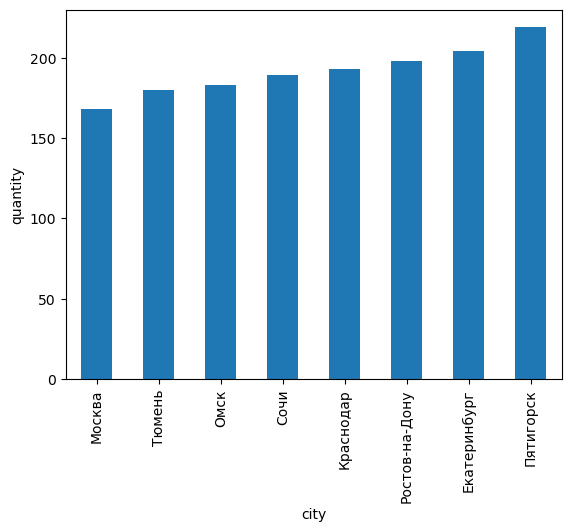

In [21]:
users['city'].value_counts(ascending=True).plot.bar()
plt.xlabel("city")
plt.ylabel("quantity")
plt.show()

In [22]:
users['city'].value_counts(ascending=True)

Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

Частота всех город вариируются в пределе ~ (160 - 220). Больше всех встречается Пятигорск, а реже всех Москва.

#### Соотношение пользователей с подпиской и без подписки

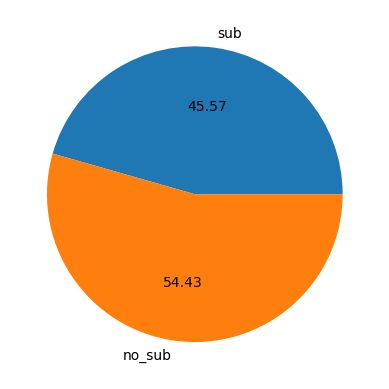

Процент пользователей с подпиской: 45.57 %
Процент пользователей без подписки: 54.43 %


In [23]:
plt.pie(users['subscription_type'].value_counts(ascending=True) / len(users['subscription_type']), labels = ['sub', 'no_sub'], autopct = '%.2f')
plt.show()
print('Процент пользователей с подпиской:', round(len(users[users['subscription_type'] == 'ultra']) / len(users['subscription_type']), 4) * 100, '%')
print('Процент пользователей без подписки:', round(len(users[users['subscription_type'] == 'free']) / len(users['subscription_type']), 4) * 100, '%')

Соотношение пользователей с подпиской и без примерно одинаковое - 46% и 54%.

#### Возраст пользователей

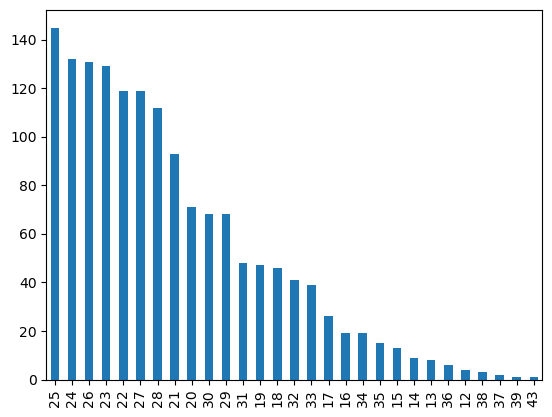

In [24]:
users['age'].value_counts(ascending=False).plot.bar()
plt.show()

<Axes: xlabel='age', ylabel='Density'>

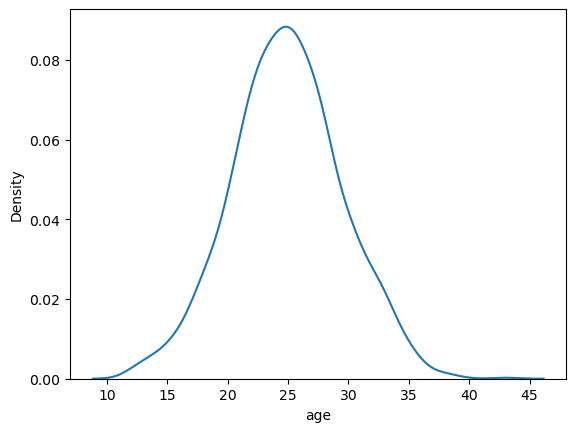

In [25]:
sns.kdeplot(x=users['age'])

Самый распространённый возраст среди пользователей - 25 лет, самый редкий - 43. В основном сервисом пользуются молодые люди в возрастном интервале от 20 до 30 лет.

#### Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

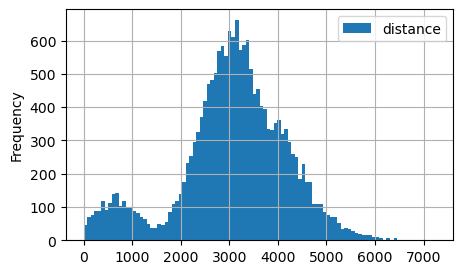

In [26]:
rides.plot(y = 'distance', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,7250))
rides['distance'].describe()

In [27]:
# избавимся от выбросов
low_percentele = 0.01
hihg_percentele = 0.99

distance_low = rides['distance'].quantile(low_percentele)
distance_high = rides['distance'].quantile(hihg_percentele)

print(f'Нижняя граница price {distance_low}')
print(f'Верхняя граница price {distance_high}')

print(
    'Процент отброшенных значений = ',
    round(
        100 - len(rides.query('@distance_low <= distance <= @distance_high'))
        / len(rides['distance']) * 100,
        2
    ),
    '%'
)
rides = rides.query('@distance_low <= distance <= @distance_high')

Нижняя граница price 208.08440510728332
Верхняя граница price 5478.621527829257
Процент отброшенных значений =  2.0 %


count    17706.000000
mean      3072.581593
std       1050.634098
min        208.752143
25%       2557.052615
50%       3133.609994
75%       3757.441386
max       5478.236130
Name: distance, dtype: float64

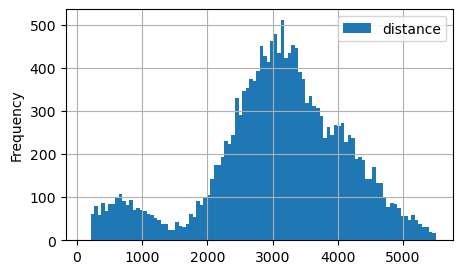

In [28]:
rides.plot(y = 'distance', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (100,5500))
rides['distance'].describe()

    По графику видно, что клиентов можно разделить на условные 2 группы: те, кто использует сервис для коротких поездок ~ 1 км и тех, кто ездит на дистанции около 3 км.
    При чём преобладает вторая категория (в 5 раз).

#### Продолжительность поездок

count    17706.000000
mean        17.869191
std          5.971199
min          0.500000
25%         13.711558
50%         17.709613
75%         21.709773
max         40.823963
Name: duration, dtype: float64

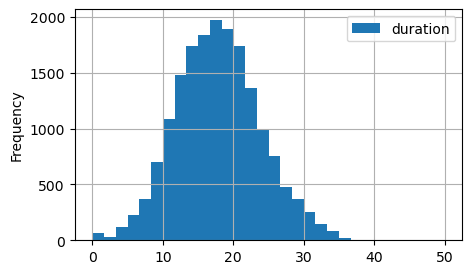

In [29]:
rides.plot(y = 'duration', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (0,50))
rides['duration'].describe()

In [30]:
# избавимся от выбросов
low_percentele = 0.01
hihg_percentele = 0.99

dur_low = rides['duration'].quantile(low_percentele)
dur_high = rides['duration'].quantile(hihg_percentele)

print(f'Нижняя граница price {dur_low}')
print(f'Верхняя граница price {dur_high}')

print(
    'Процент отброшенных значений = ',
    round(
        100 - len(rides.query('@dur_low <= duration <= @dur_high'))
        / len(rides['duration']) * 100,
        2
    ),
    '%'
)
rides = rides.query('@dur_low <= duration <= @dur_high')

Нижняя граница price 4.6902581500641025
Верхняя граница price 32.42485498842948
Процент отброшенных значений =  2.01 %


median: 17.709613
count    17350.000000
mean        17.860368
std          5.589916
min          4.709504
25%         13.783882
50%         17.709613
75%         21.614313
max         32.422181
Name: duration, dtype: float64


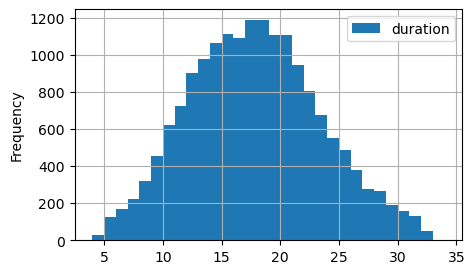

In [31]:
rides.plot(y = 'duration', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (4,34))
print('median:', round(rides['duration'].median(), 6))
print(rides['duration'].describe())

Время поездок распределено максимально равномерно, медиана близка к среднему равному 17.86 минут.

### Объединение данных

#### Объединение данных о пользователях, поездках и подписках

In [32]:
data = (users.merge(rides, on='user_id', how='left')).merge(subscriptions, on='subscription_type', how='left')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


#### Проверка на пропуски и соответствие размеру

In [33]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [34]:
print(data.shape)
print(users.shape)
print(rides.shape)
print(subscriptions.shape)

(17350, 12)
(1534, 5)
(17350, 5)
(2, 4)


Пропусков нет и размер нового датафрейма соответствует ожиданиям. 

#### Создание новых датафреймов

In [35]:
# пользователи из data без подписки
no_sub = data.query('subscription_type == "free"')
# пользователи из data с подпиской
sub = data.query('subscription_type == "ultra"')

#### Расстояние и время поездок для обеих категорий

"Пользователи с подпиской"
count    6410.000000
mean     3104.154360
std       827.117526
min       244.210438
25%      2781.338982
50%      3142.606593
75%      3543.410744
max      5419.684636
Name: distance, dtype: float64


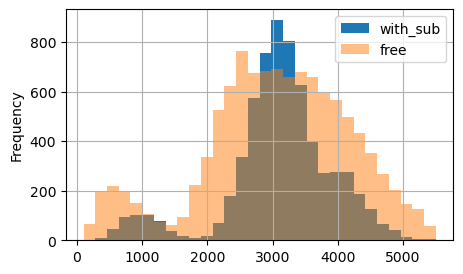

"Пользователи без подписки"
count    10940.000000
mean      3049.485930
std       1126.256648
min        208.752143
25%       2401.801282
50%       3105.492880
75%       3856.901729
max       5478.236130
Name: distance, dtype: float64


In [36]:
# расстояние поездок пользователей с подпиской
ax = sub.plot(y = 'distance', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (100, 5500), label='with_sub', alpha=1)
print('"Пользователи с подпиской"')
print(sub['distance'].describe())


# расстояние поездок пользователей без подписки
no_sub.plot(y = 'distance', kind = 'hist', bins = 30, grid=True, ax = ax, figsize = (5,3), range = (100, 5500),
    label='free', legend=True, alpha=0.5)
plt.show()
print('"Пользователи без подписки"')
print(no_sub['distance'].describe())

    Пользователи с и без подписки обычно проезжают примерно одинаковое расстояние,
    но пользователи с подпиской чаще проезжают дистанцию близкую к 3 км.

Пользователи с подпиской
count    6410.000000
mean       18.352501
std         5.281740
min         4.832212
25%        14.485587
50%        18.094780
75%        21.732347
max        32.422181
Name: duration, dtype: float64


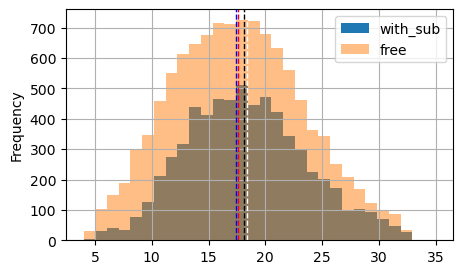

Красная и синия линии - среднее и медиана пользователей без подписки
Белая и чёрная линии - среднее и медиана пользователей с подпиской


Пользователи без подписки
count    10940.000000
mean        17.572016
std          5.743508
min          4.709504
25%         13.304911
50%         17.421327
75%         21.520679
max         32.405428
Name: duration, dtype: float64


In [37]:
# продолжительность поездок пользователей с подпиской
ax = sub.plot(y = 'duration', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (4,35), label='with_sub', alpha=1)
print('Пользователи с подпиской')
print(sub['duration'].describe())


# продолжительность поездок пользователей без подписки
no_sub.plot(y = 'duration', kind = 'hist', bins = 30, grid=True, ax = ax, figsize = (5,3), range = (4,35),
    label='free', legend=True, alpha=0.5)

plt.axvline(x=np.nanmean(no_sub['duration']), color='red', linestyle='--', linewidth=1, label='avg_no_sub')
plt.axvline(x=np.nanmedian(no_sub['duration']), color='blue', linestyle='--', linewidth=1, label='median_no_sub')
plt.axvline(x=np.nanmean(sub['duration']), color='white', linestyle='--', linewidth=1, label='avg_sub')
plt.axvline(x=np.nanmedian(sub['duration']), color='black', linestyle='--', linewidth=1, label='median_sub')
plt.show()
print('Красная и синия линии - среднее и медиана пользователей без подписки')
print('Белая и чёрная линии - среднее и медиана пользователей с подпиской')
print()
print()
print('Пользователи без подписки')
print(no_sub['duration'].describe())

Пользователи с и без подписки проводят примерно одинаковое время в поездках.

###  Подсчёт выручки

#### Суммарное расстояние, количество поездок и время для каждого пользователя за каждый месяц

In [38]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [39]:
sum_pivot = data.pivot_table(index=['user_id', 'month'], values=['distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'], aggfunc=['sum', 'count'])
sum_pivot.columns = ['distance', 'duration', 'minute_price', 'start_price', 'subscription_fee', 'qw1', 'qw2', 'qw3', 'qw4', 'rides']
sum_pivot = sum_pivot.drop(columns=['qw1', 'qw2', 'qw3', 'qw4'])
sum_pivot['duration'] = np.ceil(sum_pivot['duration']).astype('int')
sum_pivot['distance'] = round(sum_pivot['distance'], 2)
sum_pivot['minute_price'] = (sum_pivot['minute_price'] / sum_pivot['rides']).astype('int')
sum_pivot['subscription_fee'] = (sum_pivot['subscription_fee'] / sum_pivot['rides']).astype('int')

sum_pivot.head()
#display(sum_pivot.style.background_gradient(cmap='Blues', axis=0))

distance  duration  minute_price  start_price  \
user_id month                                                  
1       1       7027.51        42             6            0   
        4        754.16         7             6            0   
        8       6723.47        45             6            0   
        10      5809.91        32             6            0   
        11      7003.50        54             6            0   

               subscription_fee  rides  
user_id month                           
1       1                   199      2  
        4                   199      1  
        8                   199      2  
        10                  199      2  
        11                  199      3

#### Помесячная выручка

In [40]:
sum_pivot['revenue'] = sum_pivot['duration'] * sum_pivot['minute_price'] \
                + sum_pivot['start_price'] + sum_pivot['subscription_fee']
sum_pivot.head()

distance  duration  minute_price  start_price  \
user_id month                                                  
1       1       7027.51        42             6            0   
        4        754.16         7             6            0   
        8       6723.47        45             6            0   
        10      5809.91        32             6            0   
        11      7003.50        54             6            0   

               subscription_fee  rides  revenue  
user_id month                                    
1       1                   199      2      451  
        4                   199      1      241  
        8                   199      2      469  
        10                  199      2      391  
        11                  199      3      523

###  Проверка гипотез

#### Тратят ли пользователи с подпиской больше времени на поездки? 

In [45]:
# Нулевая гипотеза: пользователи с подпиской тратят столько же времени на поездки как и пользователи без подписки
# Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки


# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(sub['duration'], no_sub['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: пользователи с подпиской тратят значимо меньше времени на поездки')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки')

p-value: 3.1580537835376723e-19
Отвергаем нулевую гипотезу: пользователи с подпиской тратят значимо меньше времени на поездки


#### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

In [42]:
# Нулевая гипотеза: среднее расстояние равно 3130м
# Альтернативная гипотеза: среднее расстояние значимо меньше 3130м

dist = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    sub['distance'], 
    dist,
      alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: среднее расстояние, которое проезжают пользователи с подпиской\nза одну поездку, значимо меньше 3130 метров')
else:
    print('Не отвергаем нулевую гипотезу: среднее расстояние, которое проезжают пользователи с подпиской\nза одну поездку, достигает отметки в 3130 метров')

p-значение: 0.006190904206774538
Отвергаем нулевую гипотезу: среднее расстояние, которое проезжают пользователи с подпиской
за одну поездку, значимо меньше 3130 метров


#### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

In [43]:
def func(x, y):
    if x == "ultra":
        return (6 * y)
    else:
        return (8 * y + 50)
    
data['revenue'] = data.apply(lambda row: func(row['subscription_type'], row['duration']), axis=1)


sub = data.query('subscription_type == "ultra"')
no_sub = data.query('subscription_type != "ultra"')

In [44]:
ax = sub.pivot_table(index='month', values='revenue', aggfunc='sum')
ax['rev_sub'] = ax['revenue'] + 199
ax = ax.drop(columns='revenue')

pivot = no_sub.pivot_table(index='month', values='revenue', aggfunc='sum')

ax['rev_no_sub'] = pivot['revenue']

p-value: 9.530993414898447e-24
Отвергаем нулевую гипотезу


<Axes: xlabel='month'>

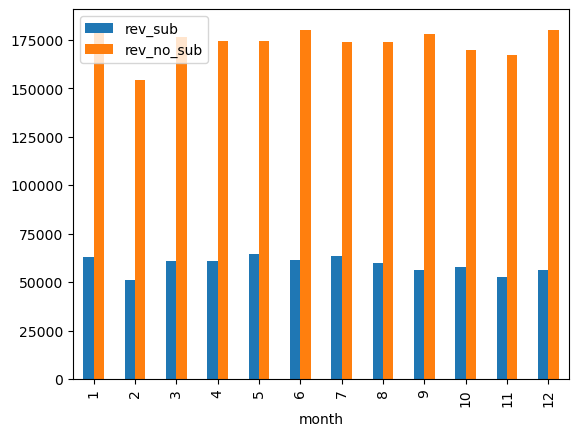

In [45]:
# Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам равна
# помесячной пользователей без подписки

# Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам меньше, 
# чем выручка от пользователей без подписки

# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(ax['rev_sub'], ax['rev_no_sub'], alternative='less')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
# визуализируем на графике
ax[['rev_sub', 'rev_no_sub']].plot.bar()

Выручка от пользователей без подписки по месяцам в разы больше чем от пользователей с подпиской.

#### Тест для проверки before / after

In [46]:
# Пример


# нулевая гипотеза: средние значения до и после обновлений равны
# альтернативная гипотеза: среднее значение обращений в поддержку до обновлений значимо больше, чем среднее 
# значение обращений в поддержку после обновлений. 


# задаём уровень значимости
alpha = 0.05

# задаём кол-во обращений в поддержку до обновлений серверов
before = [839, 675, 456, 356, 234, 543, 252, 765, 456, 875, 
          192, 262, 506, 240, 457, 968, 967, 487, 957, 967, 
          320, 193, 313, 854, 857, 477, 843, 855, 568, 855]


# задаём кол-во обращений в поддержку после обновлений серверов
after = [282, 220, 162, 226, 296, 479, 248, 322, 298, 418, 
         552, 246, 251, 404, 368, 484, 358, 264, 359, 410, 
         382, 350, 406, 416, 438, 364, 283, 314, 420, 218]
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_rel(before, after, alternative='greater')

print('Среднее до:', pd.Series(before).mean())
print('Среднее после:', pd.Series(after).mean())

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Среднее до: 586.3
Среднее после: 341.26666666666665
p-value: 2.171446837740075e-05
Отвергаем нулевую гипотезу о равенстве


Значения выборки после изменений (after) стали значительно меньше.

###  Распределения

#### 

Минимальное количество промокодов: 1161


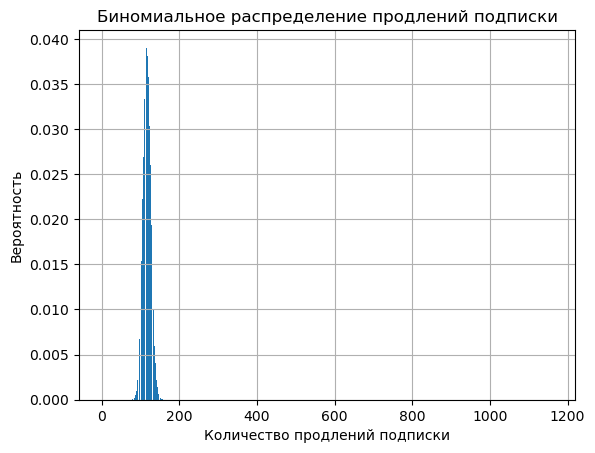

In [47]:
# Вероятность продления подписки
p = 0.1

# Требуемое количество продлений
k = 100

# Уровень значимости
alpha = 0.05

# Начнем поиск с числа равного минимальному количеству нужных продлений
n = k

# Используем цикл для нахождения минимального n, при котором вероятность P(X < k) <= 0.05
while True:
    # Расчет вероятности того, что X < k
    if binom.cdf(k-1, n, p) <= alpha:
        break
    n += 1

print(f"Минимальное количество промокодов: {n}")

# Построение графика распределения
x = np.arange(0, n+1)
pmf_vals = binom.pmf(x, n, p)
plt.bar(x, pmf_vals)
plt.title('Биномиальное распределение продлений подписки')
plt.xlabel('Количество продлений подписки')
plt.ylabel('Вероятность')
plt.grid(True)
plt.show()

#### 

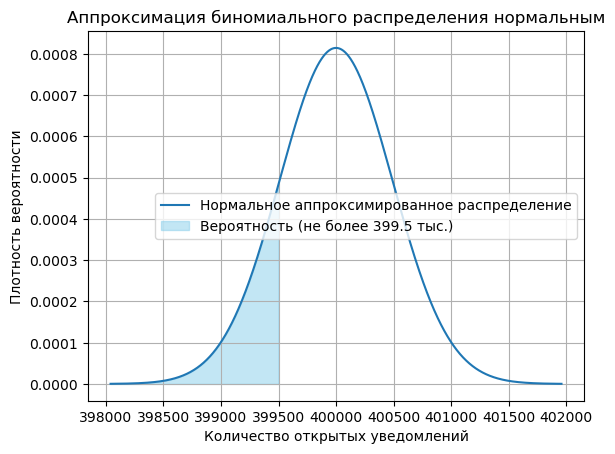

Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей равна: 0.1537


In [50]:
# Вероятность открытия уведомления
p = 0.4

# Общее количество уведомлений
n = 1000000

# Рассчитываем мат.ожидание и стандартное отклонение
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Значение, для которого вычисляем вероятность
value = 399500

# Расчет вероятности
probability = norm.cdf(value, mu, sigma)

# Построение графика
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, label='Нормальное аппроксимированное распределение')
plt.fill_between(x, y, where=(x <= value), color='skyblue', alpha=0.5, label=f'Вероятность (не более {value/1000} тыс.)')
plt.legend()
plt.title('Аппроксимация биномиального распределения нормальным')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.grid(True)
plt.show()

print(f"Вероятность того, что уведомление откроют не более {value/1000} тыс. пользователей равна: {probability:.4f}")

### Общий вывод

- В ходе исследования привели значения столбца 'date' к типу данных pandas.
- Добавили столбец с номером месяца
- Избавились от дубликатов в датафрейме users
- Отбросили выбросы в столбцах 'distance' и 'duration'
- Объедили данные в один датафрейм 'data'
- Выяснили, что частота всех городов вариируется в пределе ~ (160 - 220). Больше всех встречается Пятигорск, а реже всех Москва.
- Соотношение пользователей с подпиской и без примерно одинаковое - 46% и 54%.
- Самый распространённый возраст среди пользователей - 25 лет, самый редкий - 43. В основном сервисом пользуются молодые люди в возрастном интервале от 20 до 30 лет.
- Пользователи с подпиской тратят значимо меньше времени на поездки.
- Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, значимо меньше 3130 метров.

    Выручка от пользователей без подписки по месяцам в разы больше чем от пользователей с подпиской.
По данным анализа можно сделать вывод, что пользователей без подписки больше и они приносят большую среднюю рентабильность. Также обе категории проводят примерно одинаковое время в поездках и проезжают почти одинаковые дистанции. Для увеличения прибыли сервиса GoFast следует увеличить стоимость за подписку. Это уменьшит кол-во подписавшихся и увеличит кол-во пользователей без подписки. Также те, кто решит продлить подписку по более высокой цене, будут увеличивать среднюю прибыль этой категории из-за изменений в ценовой политике.